<a href="https://colab.research.google.com/github/D4ve39/pythonProg/blob/master/MachineLearning_DL_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Workshop 2021 - Deep Learning
# Convolutional Neural Networks

Now that we have grown familiar with simple MLPs, it is time to get down to business. As a matter of fact, you might realize that MLPs are not only very general models: they are way too general, considering our goal.

Images are structured data: if we permute their features (pixels), we change their semantics. As soon as we realize that each feature is mostly important with respect to neighbouring features, we can restrict our model class and learn much stronger models.

This is in general a good idea: if we have prior information on our task, it might be good to restrict our funciton class to account for the information. This makes finding the right function much easier.

In [ ]:
# once again, we import the libraries we will use

import numpy as np  # to deal with matrix and numerical computation
import matplotlib as mpl
mpl.rc('image', cmap='gray')
import matplotlib.pyplot as plt  # our loyal plotting library
import pandas as pd  # great tool for managing datasets
from sklearn.model_selection import train_test_split  # good old splitting function
from sklearn import datasets

# our neural network libraries of choice

import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras import layers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data preparation

When we dealt with MLPs, we carefully flattened each image to a 1D vector. However, this destroyed most of the spatial interaction between pixels. This time, we will make sure that images retain their shape.

Moreover, we are switching to a somewhat more interesting dataset called CIFAR10.
CIFAR10 contains 60k images belonging to 10 classes:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

In [ ]:
(training_data, training_labels), (test_data, test_labels) = keras.datasets.cifar10.load_data()
labels = {i: l for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}

170500096/170498071 [==============================] - 11s 0us/step


In [ ]:
# for computational reasons, we only keep the first 4 classes
num_classes = 4

to_keep = np.where(training_labels < num_classes)[0]
print(to_keep.shape)
training_data = training_data[to_keep]
training_labels = training_labels[to_keep]
to_keep = np.where(test_labels < num_classes)[0]
test_data = test_data[to_keep]
test_labels = test_labels[to_keep]

# as always, we do some preprocessing

training_data = training_data.astype(np.float32) / 255
test_data = test_data.astype(np.float32) / 255
training_labels = keras.utils.to_categorical(training_labels)
test_labels = keras.utils.to_categorical(test_labels)

(20000,)


In [ ]:
# same statistics as before, but some outputs are now different
print('data shape: {}'.format(training_data.shape[1:]))
print('# training samples: {}'.format(training_data.shape[0]))
print('# test samples: {}'.format(test_data.shape[0]))
print('# classes: {}'.format(training_labels.shape[1]))

data shape: (32, 32, 3)
# training samples: 20000
# test samples: 4000
# classes: 4


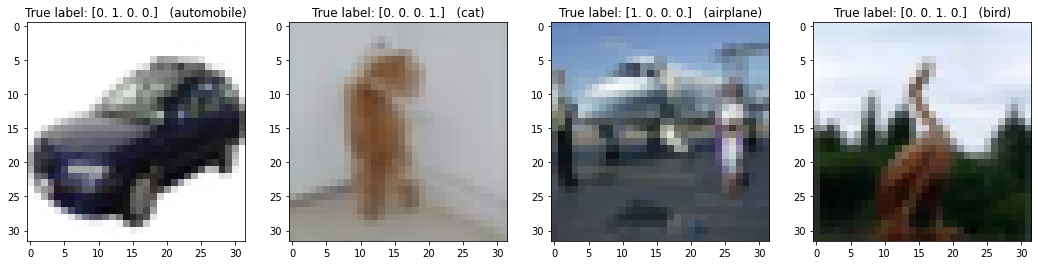

In [ ]:
# finally, let us plot some examples:

images_to_plot = 4  # number of samples to show
fig, ax = plt.subplots(1, images_to_plot, figsize=(18, 4.5))
for i in range(images_to_plot):
    rnd_id = np.random.randint(len(training_data))  # pick a random index in the training set
    rnd_img = training_data[rnd_id]  # reshape from vector to matrix
    rnd_lbl = training_labels[rnd_id]
    ax[i].imshow(rnd_img)
    ax[i].set_title(f'True label: {rnd_lbl}   ({labels[int(rnd_lbl@np.arange(num_classes))]})')
plt.show()

## Convolutional Neural Networks

As we previously mentioned, CNNs mainly contain 3 types of layers:

- convolutional layers
- pooling layers
- fully connected layers

As we are already familiar with the last kind, we will now have a look at the first two...

## Convolutional Layers

Convolutional layers are constrained to represent a convolutional operator. A convolutional operator computes the similarity of each patch in the input image with a finite signal called a kernel. Due to the properties of convolutions, the operator is 'structure-aware' and its output depends not only on features, but also on their relative positions. Due to these constraints, the number of effective parameters in the layer is massively reduced and, as a result, convolutional layers are in general easier and faster to train.

Let us have a look at what the output of a convolution looks like. We will try to apply a random kernel and a hand-designed one.

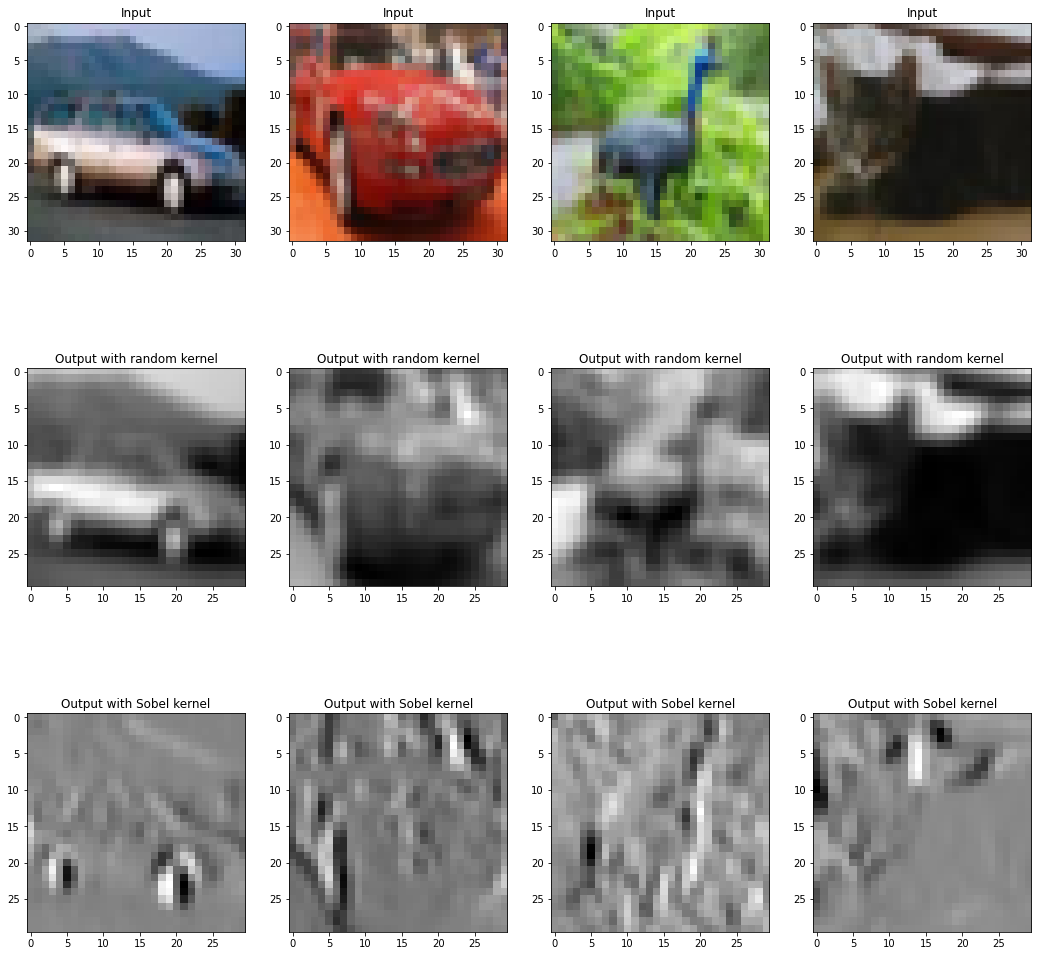

In [ ]:
random_kernel = tf.random.uniform(shape=[3, 3, 3, 1])
sobel_kernel = np.array([[-1., 0., 1.],
                         [-2., 0., 2.],
                         [-1., 0., 1.]]).astype(np.float32)
sobel_kernel = np.stack([sobel_kernel]*3, axis=2).reshape(3, 3, 3, 1)
sobel_kernel = tf.convert_to_tensor(sobel_kernel)


n_samples = 4
fig, ax = plt.subplots(3, n_samples, figsize=(18, 18))
for i in range(n_samples):
    x = training_data[[i]]
    ax[0, i].imshow(x[0])
    ax[0, i].set_title('Input')
    rnd_features = keras.backend.conv2d(x, random_kernel).numpy()[0, :, :, 0]
    ax[1, i].imshow(rnd_features)
    ax[1, i].set_title('Output with random kernel')
    edges = keras.backend.conv2d(x, sobel_kernel).numpy()[0, :, :, 0]
    ax[2, i].imshow(edges)
    ax[2, i].set_title('Output with Sobel kernel')

plt.show()

## Pooling layers
Pooling layers have a very simple task: they aggregate local information. In practice, they reduce the resolution of their inputs. Alternating convolutional and pooling layers can intuitively extract hierarchical features from the input.

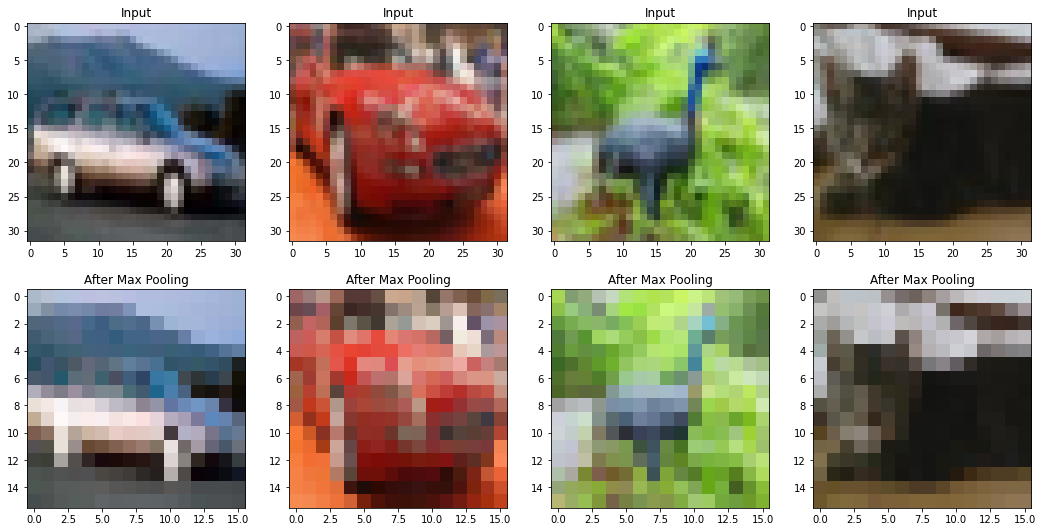

In [ ]:
max_pool_2d = tf.keras.layers.MaxPooling2D()

n_samples = 4
fig, ax = plt.subplots(2, n_samples, figsize=(18, 9))
for i in range(n_samples):
    x = training_data[[i]]
    ax[0, i].imshow(x[0])
    ax[0, i].set_title('Input')
    pooled_features = max_pool_2d(x)[0]
    ax[1, i].imshow(pooled_features)
    ax[1, i].set_title('After Max Pooling')
plt.show()

## Putting it all together

Now that we understand what operations are encoded in the layers, we can try building (and training) a CNN.

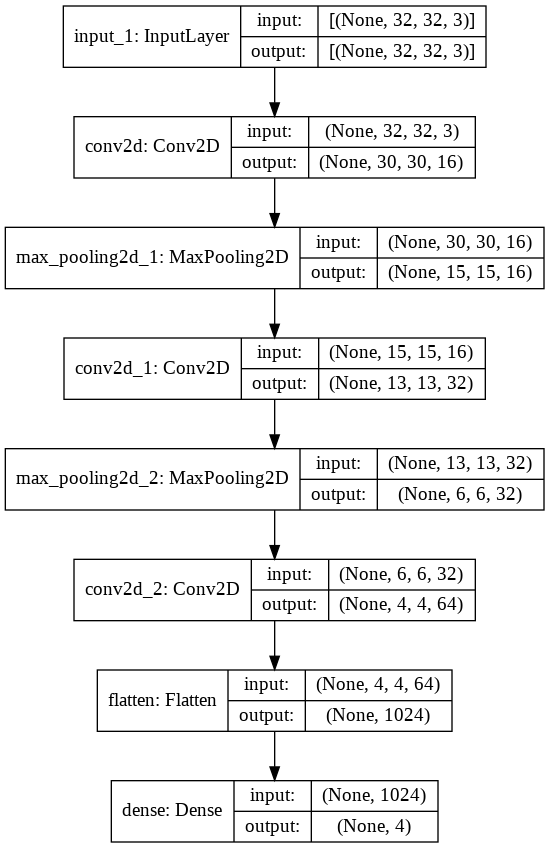

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3,)),
        layers.Conv2D(filters=16, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ]
)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 20
model.compile(
    optimizer=keras.optimizers.SGD(5e-2),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

batch_size = 64
history = model.fit(training_data, training_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
282/282 [==============================] - 3s 9ms/step - loss: 1.2893 - accuracy: 0.3954 - val_loss: 1.0726 - val_accuracy: 0.5505
Epoch 2/20
282/282 [==============================] - 2s 7ms/step - loss: 0.9559 - accuracy: 0.6081 - val_loss: 0.7899 - val_accuracy: 0.6895
Epoch 3/20
282/282 [==============================] - 2s 7ms/step - loss: 0.8024 - accuracy: 0.6677 - val_loss: 0.7227 - val_accuracy: 0.6995
Epoch 4/20
282/282 [==============================] - 2s 7ms/step - loss: 0.7308 - accuracy: 0.6956 - val_loss: 0.8536 - val_accuracy: 0.6375
Epoch 5/20
282/282 [==============================] - 2s 7ms/step - loss: 0.6918 - accuracy: 0.7218 - val_loss: 0.8713 - val_accuracy: 0.6455
Epoch 6/20
282/282 [==============================] - 2s 7ms/step - loss: 0.6594 - accuracy: 0.7423 - val_loss: 0.8415 - val_accuracy: 0.6670
Epoch 7/20
282/282 [==============================] - 2s 7ms/step - loss: 0.6345 - accuracy: 0.7500 - val_loss: 0.6562 - val_accuracy: 0.7355
Epoch 

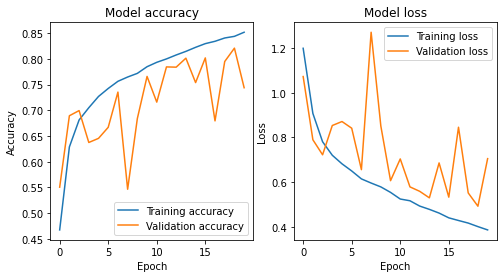

Final training accuracy: 0.8519444465637207
Final validation accuracy: 0.7440000176429749
Final training loss: 0.386610746383667
Final validation loss: 0.7053840756416321


In [ ]:
def show_history(h, show_plots=False):
    if show_plots:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(history.history['accuracy'], label='Training accuracy')
        ax[0].plot(history.history['val_accuracy'], label='Validation accuracy')
        ax[0].set_title('Model accuracy')
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[0].legend(loc='lower right')
        ax[1].plot(history.history['loss'], label='Training loss')
        ax[1].plot(history.history['val_loss'], label='Validation loss')
        ax[1].set_title('Model loss')
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(loc='upper right')
        plt.show()
    print('Final training accuracy: {}'.format(history.history['accuracy'][-1]))
    print('Final validation accuracy: {}'.format(history.history['val_accuracy'][-1]))
    print('Final training loss: {}'.format(history.history['loss'][-1]))
    print('Final validation loss: {}'.format(history.history['val_loss'][-1]))

show_history(history, show_plots=True)

Let us do some visual inspection on the predictions on the test set.

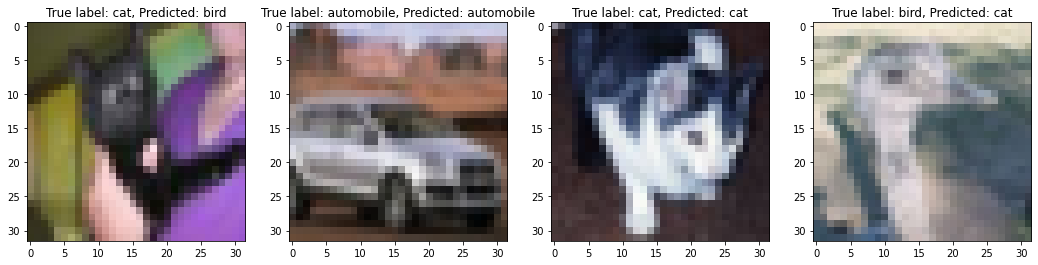

In [ ]:
images_to_plot = 4  # number of samples to show
fig, ax = plt.subplots(1, images_to_plot, figsize=(18, 4.5))
for i in range(images_to_plot):
    rnd_id = np.random.randint(len(test_data))  # pick a random index in the training set
    rnd_img = test_data[[rnd_id]]  # reshape from vector to matrix
    rnd_lbl = test_labels[rnd_id]
    predicted_lbl = labels[np.argmax(model.predict(rnd_img))]
    ax[i].imshow(rnd_img[0])
    ax[i].set_title(f'True label: {labels[int(rnd_lbl@np.arange(num_classes))]}, Predicted: {predicted_lbl}')
plt.show()

## What did the network learn?

Let us finally have a look at what the learned filters look like and try to compute feature maps on some training samples.

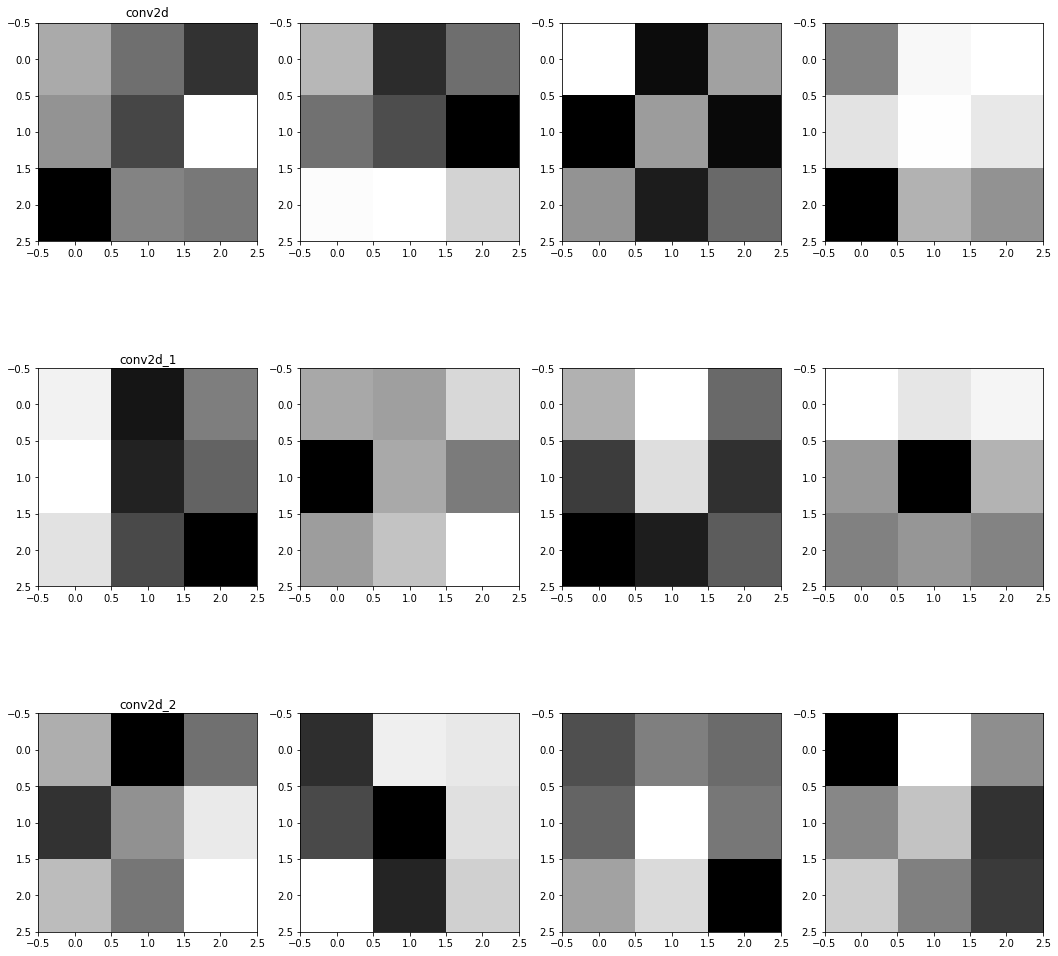

In [ ]:
# visualize filters

conv_layers = [l for l in model.layers if 'conv' in l.name]

fig, ax = plt.subplots(len(conv_layers), 4, figsize=(18,18))
for i, layer in enumerate(conv_layers):
    filters, biases = layer.get_weights()
    for j in range(4):
        f = filters[:, :, 0, j]
        f = (f - np.min(f))/(np.max(f)/np.max(f))
        ax[i, j].imshow(f)
    ax[i, 0].set_title(layer.name)

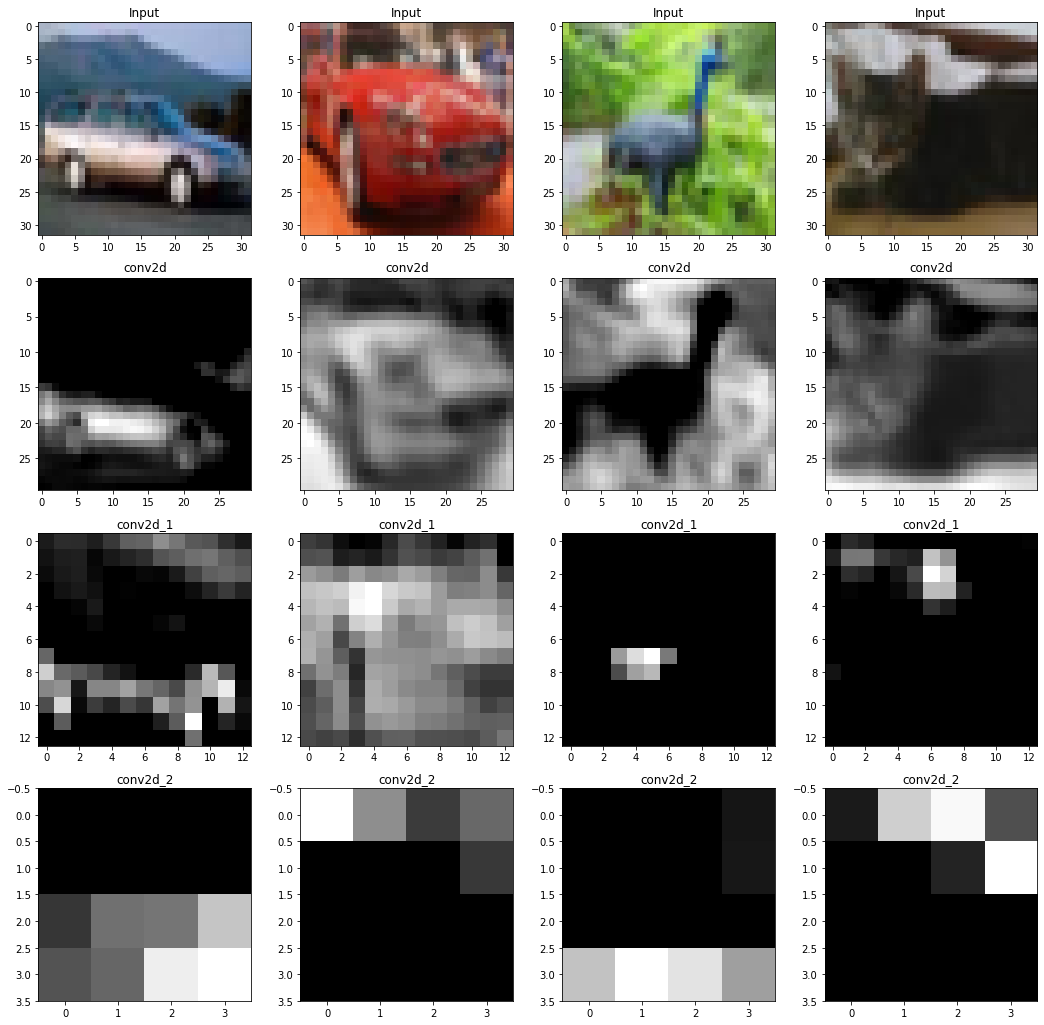

In [ ]:
conv_layers = [l for l in model.layers if 'conv' in l.name]

n_samples = 4
fig, ax = plt.subplots(1+len(conv_layers), n_samples, figsize=(18, 18))
for i in range(n_samples):
    x = training_data[[i]]
    ax[0, i].imshow(x[0])
    ax[0, i].set_title('Input')
    
    for j, layer in enumerate(conv_layers):
        tmp_model = keras.Model(inputs=model.inputs, outputs=layer.output)
        f = tmp_model.predict(x)[0, :, :, 0]
        f = (f - np.min(f))/(np.max(f)/np.max(f))
        ax[j+1, i].imshow(f)
        ax[j+1, i].set_title(layer.name)
plt.show()

### Your turn: add batch normalization!

Batch normalization is a technique that dynamically normalizes the output of a layer. Intuitively, this prevents deep layers to receive very large or very small values as input. In *keras*, batch normalization is simply implemented as a layer. Tip: default parameters should be fine!

In [ ]:
# layer.BatchNormalization() is the keras layer that takes care of batch normalization

model = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3,)),
        layers.Conv2D(filters=16, kernel_size=3, activation='relu'),
        # ...
        layers.MaxPooling2D(),
        layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        # ...
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        # ...
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ]
)

epochs = 10
model.compile(
    optimizer=keras.optimizers.SGD(5e-2),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

batch_size = 64
history = model.fit(training_data, training_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
282/282 [==============================] - 3s 8ms/step - loss: 1.2950 - accuracy: 0.3857 - val_loss: 1.1407 - val_accuracy: 0.5180
Epoch 2/10
282/282 [==============================] - 2s 7ms/step - loss: 0.9872 - accuracy: 0.5971 - val_loss: 0.8732 - val_accuracy: 0.6395
Epoch 3/10
282/282 [==============================] - 2s 7ms/step - loss: 0.8160 - accuracy: 0.6672 - val_loss: 0.8659 - val_accuracy: 0.6420
Epoch 4/10
282/282 [==============================] - 2s 7ms/step - loss: 0.7665 - accuracy: 0.6949 - val_loss: 0.9263 - val_accuracy: 0.6310
Epoch 5/10
282/282 [==============================] - 2s 7ms/step - loss: 0.6949 - accuracy: 0.7194 - val_loss: 0.7674 - val_accuracy: 0.6755
Epoch 6/10
282/282 [==============================] - 2s 7ms/step - loss: 0.6496 - accuracy: 0.7397 - val_loss: 0.7521 - val_accuracy: 0.7135
Epoch 7/10
282/282 [==============================] - 2s 7ms/step - loss: 0.6257 - accuracy: 0.7566 - val_loss: 0.6833 - val_accuracy: 0.7160
Epoch 

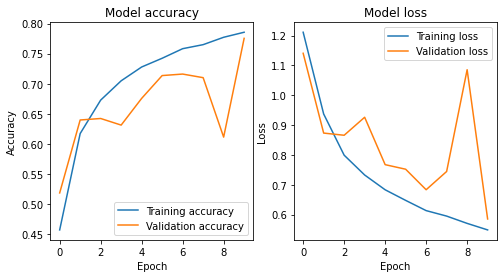

Final training accuracy: 0.7856666445732117
Final validation accuracy: 0.7754999995231628
Final training loss: 0.5485599040985107
Final validation loss: 0.5852214097976685


In [ ]:
show_history(history, show_plots=True)

What can you observe from the plots?

BONUS: if you have more time, please notice that we specified the optimizer in a different way. We specified is as an object instead of a string. This way we can explicitly set the optimizer's hyperparameters parameters. The one parameter that is passed to the optimizer is its learning rate. Try increasing and lowering it and see what it does.

### Your turn: back to MNIST!

Use your best CNN architecture and see if you can improve accuracy on MNIST compared to MLPs.

In [ ]:
digits = datasets.fetch_openml('mnist_784', version=1)
data = digits.data  # get features
data = data.astype(np.float32) / 255  # we normalize the data to avoid extreme values

data = data.reshape((-1, 28, 28, 1))  # we do not want our input to be a 1D vector! We should reshape it to square greyscale images of 28 pixels per side.

labels = digits.target  # get labels
labels = keras.utils.to_categorical(labels)  # we are using one-hot labels to handle vectorized outputs
training_data, test_data, training_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
model = keras.Sequential(
    [
        # ...

    ]
)


epochs = 10
model.compile(
    optimizer=keras.optimizers.SGD(5e-2),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

batch_size = 64
history = model.fit(training_data, training_labels, batch_size=batch_size, epochs=epochs, validation_split=0.1)

788/788 [==============================] - 5s 6ms/step - loss: 0.0604 - accuracy: 0.9816 - val_loss: 0.0534 - val_accuracy: 0.9827
Epoch 5/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0515 - accuracy: 0.9839 - val_loss: 0.0629 - val_accuracy: 0.9802
Epoch 6/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0429 - accuracy: 0.9872 - val_loss: 0.0704 - val_accuracy: 0.9770
Epoch 7/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0384 - accuracy: 0.9876 - val_loss: 0.0380 - val_accuracy: 0.9866
Epoch 8/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.0372 - val_accuracy: 0.9884
Epoch 9/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.0337 - val_accuracy: 0.9889
Epoch 10/10
788/788 [==============================] - 5s 6ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0349 - val_accuracy: 0.9879


In [ ]:
show_history(history, show_plots=True)